In [17]:
import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from shapely import wkb

import stackstac
import pystac_client
import numpy as np
import dask
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import xarray as xr
import rioxarray as rxr

import torch.nn as nn

import shapely
from rasterio.features import rasterize
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

import seaborn as sns

warnings.filterwarnings("ignore")

### Get embeddings for a given region

In [ ]:
# Read in embeddings for a given region
embeddings = gpd.read_parquet('data/ga_256_2022-06-01_2022-08-31_tile_embeddings_final_1933.parquet')
aoi = embeddings.geometry.unary_union # Get AOI that embeddings cover

print(f'Number of embeddings: {len(embeddings)}')
print(embeddings.crs)

Number of embeddings: 1933
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degre

#### Label embeddings with presence or absence of pit lake

##### Get labeled pit lakes from Aquarry QA dataset


In [26]:
# Load Aquarry QA'ed data
psql_bboxes = gpd.read_file('data/aquarry_psql_layer.csv')
psql_bboxes = gpd.GeoDataFrame(psql_bboxes,geometry = psql_bboxes['field_8'].apply(wkb.loads),crs='epsg:4326') # Convert WKB geometry

psql_bboxes.columns = ['cc', 'objectid', 'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry','field_9', 'category', 'field_11', 'geometry']

# Get confirmed pit lakes in the given AOI
aoi_bboxes = psql_bboxes[psql_bboxes.geometry.intersects(aoi)]
print(f'Features confirmed as pit lakes or questionable during QA: {(aoi_bboxes['category'].isin(['a', 'q'])).sum()}')

# Ensure CRS alignment
crs = embeddings.crs 
aoi_bboxes = aoi_bboxes.to_crs(crs)

Features confirmed as pit lakes or questionable during QA: 279


##### Label embeddings

In [8]:
# Define function that marks each chip in intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(embeddings, polygons):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    embeddings (GeoDataFrame): positive chip embeddings
    polygons (GeoDataFrame): pit lakes intersecting with the given AOI
    
    Returns:
    data_flat (GeoDataFrame): embedding chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    data = gpd.sjoin(embeddings, polygons, predicate='intersects',how = 'left',rsuffix="_1")
    data['mine'] = 0 # Initialize column
    data.loc[~data['index__1'].isna(), 'mine'] = 1 # Assign 1 if intersects with pit lakes

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.

    # Drop duplicates if you want to keep only one row per index
    data = data.drop_duplicates(subset=['geometry'])

    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    # Flatten embedding to an array of length 1024
    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    return data_flat

In [9]:
# Label chips with pit lakes
data = LabelEmbeddings1_5(embeddings, aoi_bboxes)

Number of positive samples: 231


### Run MLP classifier model on embeddings

##### Create embedding dataset

In [15]:
# Define model dataset class
class MLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (torch.Tensor): Input embeddings with shape (num_samples, 1024).
            labels (torch.Tensor): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [20]:
embeddings_array = data['embedding']
labels_array = data['mine']

embs_dataset = MLPDataset(embeddings_array, labels_array)  
dataset_loader = DataLoader(embs_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

##### Run model

In [12]:
# Define model architecture
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        # Define the layers of the MLP
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Pass through the output layer and apply sigmoid for binary classification
        x = torch.sigmoid(self.output_layer(x))
        return x

In [14]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLPBinaryClassifier()
model.load_state_dict(torch.load("pit_lake_clf.pth"))
model.to(device)

MLPBinaryClassifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [21]:
# Predict pit lakes from embeddings

model.eval()
criterion = nn.BCELoss(reduction='mean') 

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []
threshold = 0.5  # Adjust this threshold to toggle precision/recall

for inputs, labels in dataset_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > threshold).float() 
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

#### Evaluate results

Precision on test set: 0.6945
Recall on test set: 0.8268
Accuracy on test set: 0.9359
F1 score on test set: 0.7549
Total chips: 1933
True positives: 231.0
Predicted positives: 275.0


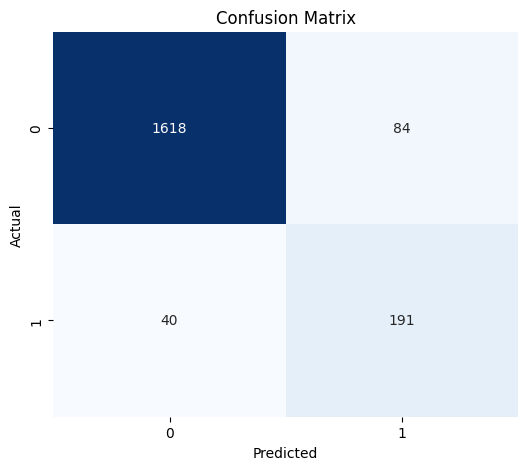

In [22]:
# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

# Confusion Matrix
cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Filter chips by NDWI to get likely pit lake polygons

##### Save pit lake polygons as CSV